## D Vamsidhar - 24070149005
### Lab 03 - Vanilla GAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [2]:
class Discriminator(nn.Module):
  def __init__(self, in_features):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Linear(in_features, 128),
        nn.LeakyReLU(0.1),
        nn.Linear(128, 1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    return self.disc(x)

In [3]:
class Generator(nn.Module):
  def __init__(self, z_dim, img_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256, img_dim),
        nn.Tanh(),   #Normalize inputs to [-1, 1] 
    ) 
  def forward(self, x):
    return self.gen(x)

In [4]:
#Hyperparameters 
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  #784
batch_size = 32
num_epochs = 50

disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5,), (0.5,)),
    ]
)

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:05<00:00, 1.76MB/s]


Extracting dataset/MNIST\raw\train-images-idx3-ubyte.gz to dataset/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting dataset/MNIST\raw\train-labels-idx1-ubyte.gz to dataset/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 600kB/s]


Extracting dataset/MNIST\raw\t10k-images-idx3-ubyte.gz to dataset/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting dataset/MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset/MNIST\raw



In [7]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]


        ## Train disciminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake)/2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min_log(1 - D(G(z))) <-> max log(D(G(z)))
        # where the second option of maximizing doesn't suffer from saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )

                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step+=1


Epoch [0/50] Batch 0/1875 Loss D: 0.6329, loss G: 0.7126
Epoch [1/50] Batch 0/1875 Loss D: 0.1955, loss G: 1.9575
Epoch [2/50] Batch 0/1875 Loss D: 0.2486, loss G: 1.6540
Epoch [3/50] Batch 0/1875 Loss D: 0.4902, loss G: 1.3277
Epoch [4/50] Batch 0/1875 Loss D: 0.2402, loss G: 2.0599
Epoch [5/50] Batch 0/1875 Loss D: 0.6183, loss G: 0.9821
Epoch [6/50] Batch 0/1875 Loss D: 0.5979, loss G: 1.1889
Epoch [7/50] Batch 0/1875 Loss D: 0.5561, loss G: 1.0053
Epoch [8/50] Batch 0/1875 Loss D: 0.4505, loss G: 1.1463
Epoch [9/50] Batch 0/1875 Loss D: 0.4453, loss G: 1.5216
Epoch [10/50] Batch 0/1875 Loss D: 0.7942, loss G: 0.7390
Epoch [11/50] Batch 0/1875 Loss D: 0.4890, loss G: 1.4684
Epoch [12/50] Batch 0/1875 Loss D: 0.6736, loss G: 1.1680
Epoch [13/50] Batch 0/1875 Loss D: 0.6551, loss G: 1.0939
Epoch [14/50] Batch 0/1875 Loss D: 0.6093, loss G: 1.0248
Epoch [15/50] Batch 0/1875 Loss D: 0.6633, loss G: 0.9623
Epoch [16/50] Batch 0/1875 Loss D: 0.4479, loss G: 1.6017
Epoch [17/50] Batch 0/18

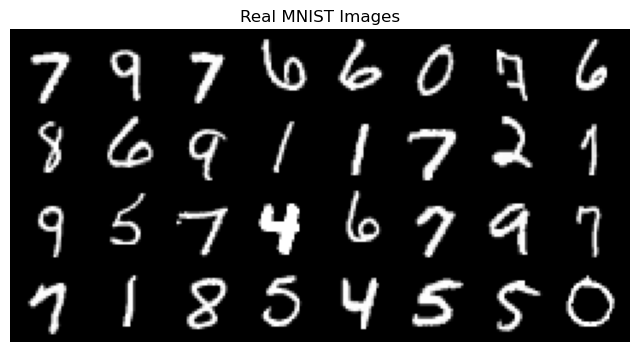

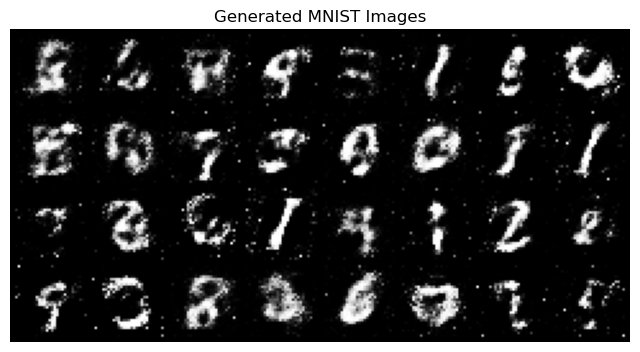

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

#Function to display images
def show_images(images, title):
  images = images.cpu().detach()  #Move to CPU and detach from gradients
  grid = make_grid(images, nrow=8, normalize = True)  #Arrange in grid
  plt.figure(figsize=(8,8))
  plt.imshow(grid.permute(1, 2, 0)) #Convert from pytorch tesor to image format
  plt.title(title)
  plt.axis('off')
  plt.show()

#Load trained Generator
device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 64 #Should match the generator input
gen.eval()


# Generate fake images
fixed_noise = torch.randn(32, z_dim).to(device)
fake_images = gen(fixed_noise).reshape(-1, 1, 28, 28)

# Load a batch of real images
real_images, _ = next(iter(loader))
real_images = real_images[:32]

# Display Real vs Generated images
show_images(real_images, "Real MNIST Images")
show_images(fake_images, "Generated MNIST Images")